In [3]:
from torch import nn
import numpy as np
import torch 
from torch.utils import data
from d2l import torch as d2l

In [4]:
true_w=torch.tensor([2,3.0])
true_b=4
features,labels=d2l.synthetic_data(true_w,true_b,1000)


In [5]:
def load_array(data_array,batch_size,is_train=True):
    data_set=data.TensorDataset(*data_array)
    return data.DataLoader(data_set,batch_size,shuffle=is_train)

In [6]:
batch_size=10
data_iter=load_array((features,labels),batch_size,True)


In [7]:
net=nn.Sequential(nn.Linear(2,1))

In [8]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [9]:
loss=nn.MSELoss()

In [10]:
trainer=torch.optim.SGD(net.parameters(),0.03)

In [11]:
num_epochs=10
for epoch in range(num_epochs):
    for X,y in data_iter:
        y_hat=net(X)
        l=loss(y_hat,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        
    l = loss(net(features), labels)
    print(f'epoch:{epoch+1} loss:{l}')

epoch:1 loss:0.000182607356691733
epoch:2 loss:0.00010383463086327538
epoch:3 loss:0.00010344846668886021
epoch:4 loss:0.00010374355042586103
epoch:5 loss:0.00010261215356877074
epoch:6 loss:0.00010260509588988498
epoch:7 loss:0.00010286425822414458
epoch:8 loss:0.00010309965728083625
epoch:9 loss:0.00010375152487540618
epoch:10 loss:0.00010319631110178307


In [12]:
class MySequential(nn.Module):
    def __init__(self,*args):
        super().__init__()
        for idx,module in enumerate(args):
            self._modules[str(idx)]=module
    
    def forward(self,X):
        for block in self._modules.values():
            X=block(X)
            
        return X
            

In [2]:
def cross(X,K):
    h,w=K.shape
    Y=torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j]=(X[i:i+h,j:j+w]*K).sum()
    return Y


In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i,h,w=X.shape
    c_o=K.shape[0]
    X.reshape(c_i,h*w)
    K.reshape(c_o,c_i)
    Y=torch.matmul(K,X)
    Y.reshape(c_o,h,w)

    return Y

In [1]:
!nvidia-smi

Thu Sep 21 08:32:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.09                 Driver Version: 532.09       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8                9W /  N/A|      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import torch
import torch.cuda

device_count = torch.cuda.device_count()
print(device_count)


1


In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.zeros(1).cuda())


2.0.1+cu118
True
tensor([0.], device='cuda:0')


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs,in_channels,out_channels):
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [3]:
conv_arch=((1,64),(1,128),(2,256),(2,512),(2,512))

In [5]:
def vgg(conv_arch):
    conv_blks=[]
    in_channels=1
    
    for (num_convs,out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
        in_channels=out_channels
        
    return nn.Sequential(*conv_blks,nn.Flatten(),
                         nn.Linear(out_channels*7*7,4096),nn.ReLU(),nn.Dropout(0.5),
                         nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
                         nn.Linear(4096,10))
    
net=vgg(conv_arch)

In [6]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'shape\t', X.shape)


Sequential shape	 torch.Size([1, 64, 112, 112])
Sequential shape	 torch.Size([1, 128, 56, 56])
Sequential shape	 torch.Size([1, 256, 28, 28])
Sequential shape	 torch.Size([1, 512, 14, 14])
Sequential shape	 torch.Size([1, 512, 7, 7])
Flatten shape	 torch.Size([1, 25088])
Linear shape	 torch.Size([1, 4096])
ReLU shape	 torch.Size([1, 4096])
Dropout shape	 torch.Size([1, 4096])
Linear shape	 torch.Size([1, 4096])
ReLU shape	 torch.Size([1, 4096])
Dropout shape	 torch.Size([1, 4096])
Linear shape	 torch.Size([1, 10])


In [7]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels,out_channels,kernel_size,strides,padding):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU(),
    )

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    def __inti__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(Inception,self).__init__(**kwargs)
        
        self.p1_1=nn.Conv2d(in_channels,c1,kernel_size=1)
        
        self.p2_1=nn.Conv2d(in_channels,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
    def forward(self,x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        
        return torch.cat((p1,p2,p3,p4),dim=1)
        

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    if not torch.is_grad_enabled():
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape)in(2,4)

        if len(X.shape)==2:
            mean=X.mean(dim=0)
            var=((X-mean)**2).mean(dim=0)
        else:
            mean=X.mean(dim=(0,2,3),keepdim=True)
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        X_hat=(X-mean)/torch.sqrt(var+eps)

        moving_mean=momentum*moving_mean+(1.0-momentum)*mean
        moving_var=momentum*moving_var+(1.0-momentum)*var
    Y=gamma*X_hat+beta
    return Y,moving_mean.data,moving_var.data

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
        super().__init__()
        self.conv1=nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,strides=strides)
        self.conv2=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)

        if use_1x1conv:
            self.conv3=nn.Conv2d(input_channels,num_channels,kernel_size=3,stride=strides)
        else:
            self.conv3=None
        
        self.bn1=nn.BatchNorm2d(num_channels)
        self.bn2=nn.BatchNorm2d(num_channels)

    def forward(self,X):
        Y=F.relu(self.bn1(self.conv1(X)))
        Y=self.bn2(self.conv2(Y))
        if self.conv3:
            X=self.conv3(X)
        Y+=X

        return F.relu(Y)

In [ ]:
b1=nn.Sequential(nn.Conv2d(1,64,7,2,3),
                 nn.BatchNorm2d(64),nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [ ]:
def resnet_block(input_channels,num_channels,num_residuals,first_block=False):
    blk=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(input_channels,num_residuals,use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(num_channels,num_channels))
    return blk

In [ ]:
b2=nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3=nn.Sequential(*resnet_block(64,128,2))
b4=nn.Sequential(*resnet_block(128,256,2))
b5=nn.Sequential(*resnet_block(256,512,2))

In [ ]:
net=nn.Sequential(b1,b2,b3,b4,b5,
                  nn.AdaptiveMaxPool2d((1,1)),
                  nn.Flatten(),nn.Linear(512,10))

In [2]:
def fun1():
    a=1
    b=2
    return a,b

In [3]:
a=fun1()
a

(1, 2)

Mean Squared Error: 2.354518926022502


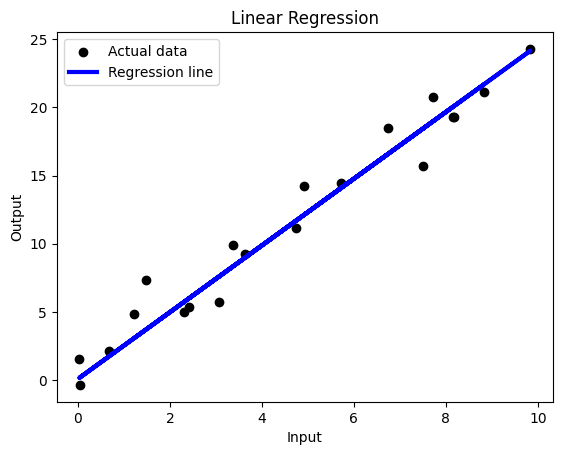

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 生成示例数据
X = np.random.rand(100, 1) * 10  # 生成100个随机点作为输入特征
Y = 2.5 * X + np.random.randn(100, 1) * 2  # 生成线性输出加上一些噪音

# 划分数据为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 初始化线性回归模型
model = LinearRegression()

# 用训练数据拟合模型
model.fit(X_train, Y_train)

# 预测测试集结果
predictions = model.predict(X_test)

# 计算和打印MSE
mse = mean_squared_error(Y_test, predictions)
print(f'Mean Squared Error: {mse}')

# 可视化
plt.scatter(X_test, Y_test, color='black', label='Actual data')
plt.plot(X_test, predictions, color='blue', linewidth=3, label='Regression line')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Linear Regression')
plt.show()


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       108
           1       0.94      0.91      0.93        92

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200



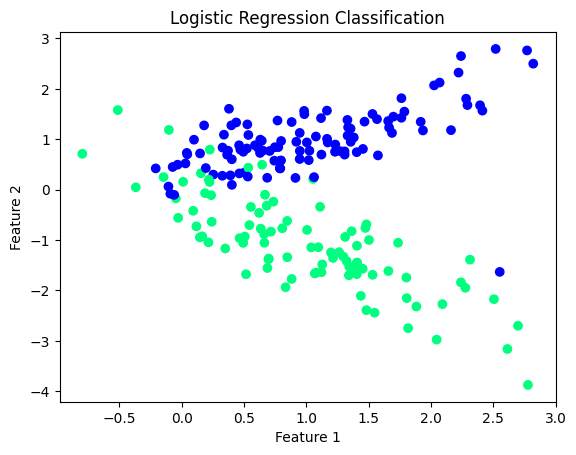

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 创建一个模拟数据集
X, Y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)

# 划分数据集为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 初始化逻辑回归模型
model = LogisticRegression()

# 使用训练数据拟合模型
model.fit(X_train, Y_train)

# 在测试集上进行预测
predictions = model.predict(X_test)

# 输出分类报告
print(classification_report(Y_test, predictions))

# 可视化
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap='winter')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Classification')
plt.show()


In [2]:
def haha(a):
    for i in range(a):
        yield i

for i in haha(3):
    print(i)

0
1
2


In [7]:
import torch
from torch.nn import functional as  F

In [17]:
x=torch.arange(6).reshape((2,3))
F.one_hot(x.T,7)

tensor([[[1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0]]])

In [1]:
from torch import nn

In [2]:
class Encoder(nn.Module):
    def __init__(self,**kwargs):
        super(Encoder,self).__init__(**kwargs)

    def forward(self,X,*args):
        raise NotImplementedError

In [3]:
class Decoder(nn.Module):
    def __init__(self,**kwargs):
        super(Decoder,self).__init__(**kwargs)

    def init_state(self,enc_outputs,*args):
        raise NotImplementedError
    
    def forward(self,X,state):
        raise NotImplementedError

In [4]:
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder,**kwargs):
        super(EncoderDecoder,self).__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def forward(self,enc_X,dec_X,*args):
        enc_outputs=self.encoder(enc_X,*args)
        dec_state=self.decoder.init_state(enc_outputs,*args)
        return self.decoder(dec_X,dec_state)